In [4]:
# 라이브러리 import
import pandas as pd
import numpy as np
import random
import os
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'
sns.set(font="Malgun Gothic")
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from xgboost import plot_importance 
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split

In [6]:
data=pd.read_csv(os.listdir()[8],encoding='EUC-KR')
data_real=pd.read_csv(os.listdir()[8],encoding='EUC-KR')
data=data.query('합계!=0')
#필요 컬럼 추출
selected_columns=['비고', '지자체명_시도', '지자체명_시군구', '구분', '농업경영체','합계', '작물 종류','농지면적(실제경작)','전년대비농경체증감률','고령농경체비율','전년도이탈인원','전년도활용여부'] #필요한 컬럼만 추출
data=data[selected_columns]
data_real=data_real[selected_columns]
data.rename(columns={'농지면적(실제경작)':'농지면적'},inplace=True)

# 데이터 확인 및 이상치 제거

# 연속형 변수 분포 확인

이상치 제거 필요 컬럼
- 농지면적 
- 합계

In [7]:
round(data[['합계','농지면적','전년대비농경체증감률','고령농경체비율','전년도이탈인원']].describe(),3)

,합계,농지면적,전년대비농경체증감률,고령농경체비율,전년도이탈인원
count,12449.000,12449.000,12449.000,12449.000,12449.000
mean,3.395,0.496,102.359,53.464,0.092
std,2.056,0.594,0.999,4.310,0.511
min,1.000,0.000,99.500,39.370,0.000
25%,2.000,0.250,101.800,51.030,0.000
50%,3.000,0.360,102.300,53.630,0.000
75%,5.000,0.550,103.000,56.230,0.000
max,13.000,22.090,107.500,63.720,11.000


# 농지면적 이상치 제거

2.555200000000004
0.04


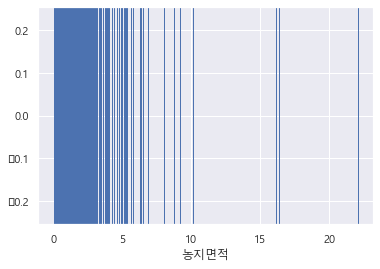

In [8]:
sns.rugplot(x='농지면적',data=data,height=1)
print(data['농지면적'].quantile(0.99)) #2.5 이상의 농지면적 모두 이상치로 판단
print(data['농지면적'].quantile(0.01)) #0.04이하의 농지면적 모두 이상치로 판단

- 분위값 확인

In [9]:
data=data.query('0.04<농지면적<2.5')

# 합계 컬럼 이상치 제거

9.0
1.0
2     4276
5     1765
4     1720
1     1645
3     1171
6      736
9      442
7      205
8      180
10      24
12       7
11       5
13       1
Name: 합계, dtype: int64


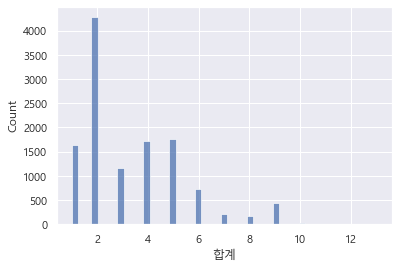

In [10]:
sns.histplot(x='합계',data=data)
print(data['합계'].quantile(0.99)) 
print(data['합계'].quantile(0.01)) 
print(data['합계'].value_counts()) #10 이상의 합계인원은 이상치로 판단하여 제거

In [11]:
data=data.query('합계<11')

# 연속형 변수 정규화

In [12]:
min_max_scaler=MinMaxScaler()
for i in data.columns:
    if (data[i].dtypes!='object') and (i not in ['비고','농업경영체','합계']):
        data[i]=min_max_scaler.fit_transform(data[[i]])
    else:
        pass

# 라벨 인코딩 진행(범주형 변수 수치형 변환)

In [13]:
label_encoder=LabelEncoder()
for i in data.columns:
    if data[i].dtypes=='object':
        data[i]=label_encoder.fit_transform(data[i])
    else:
        pass

In [14]:
data

,비고,지자체명_시도,지자체명_시군구,구분,농업경영체,합계,작물 종류,농지면적,전년대비농경체증감률,고령농경체비율,전년도이탈인원,전년도활용여부
0,2022,0,97,3,1000000327,3,0,0.143443,0.2500,0.411499,0.0,0
1,2022,0,97,3,1000000332,4,0,0.131148,0.2500,0.411499,0.0,0
2,2023,0,97,3,1000000332,2,0,0.131148,0.3750,0.505544,0.0,1
3,2022,0,97,0,1000000336,3,0,0.278689,0.2500,0.411499,0.0,0
4,2023,0,97,0,1000000336,6,0,0.278689,0.3750,0.505544,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12538,2023,9,71,0,3000461549,7,0,0.213115,0.4250,0.574127,0.0,1
12539,2023,3,34,2,3000642967,1,7,0.053279,0.2750,0.629158,0.0,0
12540,2023,8,15,2,3000851064,4,0,0.077869,0.3000,0.668583,0.0,0
12541,2023,5,60,2,3000873387,2,3,0.090164,0.3875,0.670226,0.0,1


# 모델 구축

In [15]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

# 데이터 분할

- 작물 종류 기준 데이터 분할

In [16]:
# 작물 종류 기준 층화 추출 Train Test 비율 8:2
X=data.drop(columns=['합계','농업경영체','비고']) #독립변수 Set
Y=data['합계'] #Target 변수 set
X_train, X_test, Y_train, Y_test=train_test_split(X,Y,test_size=0.2,stratify=X['작물 종류'],random_state=42)

In [17]:
# XGB regressor 모델 구축
# dart부스터 학습률 0.05, 한트리의 최대 깊이 8, 반복 학습 횟수 200회로 진행

model_reg=XGBRegressor(booster='dart',learning_rate=0.05, max_depth=8, n_estimator=200)

In [18]:
# 모델 적용
model_reg.fit(X_train,Y_train)

XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimator=200, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

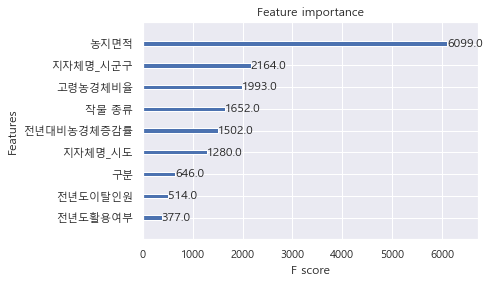

In [19]:
# 변수 중요도 확인
plot_importance(model_reg)

In [20]:
pred=model_reg.predict(X_test)

In [21]:
# 인원 수 예측이기에 예측된 결과에 반올림 적용
pred=pd.DataFrame(pred,columns=['예측값'])

In [22]:
pred['예측값']=round(pred['예측값'],0)

In [23]:
pred

,예측값
0,4.0
1,4.0
2,3.0
3,3.0
4,3.0
...,...
2428,3.0
2429,4.0
2430,5.0
2431,4.0


# MAE & mse & Rmse & Rmspe

- MAE=실제값과 예측값 사이의 절대값의 평균=> 크면 클 수록 예측력이 낮은 것
- MSE=실제값과 예측값 사이의 차이를 제곱한 평균
- RMSE=MSE에 루트를 취한 값
- RMSPE=예측 오차를 실제값으로 나눈후 제곱하여 평균을 측정한 제곱근임

In [24]:
# MAE
def Evaluation_metric(actual,pred):
    print(f'MAE: {round(mean_absolute_error(actual,pred),2)}')
    print(f'MSE: {round(mean_squared_error(actual,pred),2)}')
    print(f'RMSE: {round(sqrt(mean_squared_error(actual,pred)),2)}')
    print(f'RMSPE: {round(sqrt(mean_squared_error(actual,pred))/np.mean(actual)*100,2)}%')

In [25]:
Evaluation_metric(Y_test,pred=pred)

MAE: 1.24
MSE: 2.96
RMSE: 1.72
RMSPE: 51.0%


In [26]:
# Test data Set
test_index=X_test.index.tolist()
data_test=data_real.loc[test_index]
data_test=data_test.reset_index()
data_test.drop(columns=['index'],inplace=True)

In [27]:
data_test['predict']=pred

In [28]:
data_test

,비고,지자체명_시도,지자체명_시군구,구분,농업경영체,합계,작물 종류,농지면적(실제경작),전년대비농경체증감률,고령농경체비율,전년도이탈인원,전년도활용여부,predict
0,2023,충청북도,진천군,대농,1000573757,4,① 시설원예·특작,0.58,103.9,53.07,0.0,Y,4.0
1,2022,충청북도,진천군,대농,1001319680,5,① 시설원예·특작,1.14,102.6,51.34,0.0,N,4.0
2,2023,제주특별자치도,제주시,중농,1000972865,1,"④ 인삼, 일반채소",0.36,102.6,40.17,0.0,N,3.0
3,2023,충청남도,금산군,소농,3000828425,4,① 시설원예·특작,0.22,101.9,55.65,0.0,Y,3.0
4,2022,전라북도,무주군,대농,1002167700,2,③ 과수,0.49,102.8,55.01,0.0,N,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2428,2023,전라북도,진안군,중농,1002097077,2,③ 과수,0.30,102.4,56.76,0.0,N,3.0
2429,2023,강원도,인제군,대농,1000458922,5,① 시설원예·특작,1.02,101.4,46.95,3.0,Y,4.0
2430,2023,경상북도,김천시,중농,1000962408,2,③ 과수,0.30,103.9,52.72,0.0,N,5.0
2431,2022,충청남도,아산시,소농,1002456038,2,"④ 인삼, 일반채소",0.10,101.9,55.47,0.0,N,4.0


In [29]:
result=data_test.groupby(['지자체명_시도','지자체명_시군구'])[['합계','predict']].sum().reset_index()

In [30]:
result_1=result.query('합계>10')

In [31]:
result_1

,지자체명_시도,지자체명_시군구,합계,predict
0,강원도,삼척시,48,46.0
1,강원도,양구군,288,277.0
2,강원도,영월군,44,49.0
3,강원도,원주시,16,7.0
4,강원도,인제군,184,189.0
...,...,...,...,...
110,충청북도,음성군,163,135.0
111,충청북도,제천시,23,38.0
112,충청북도,진천군,102,108.0
113,충청북도,청주시,46,56.0


In [32]:
Evaluation_metric(result_1['합계'],pred=result_1['predict'])

MAE: 7.62
MSE: 125.35
RMSE: 11.2
RMSPE: 13.67%
